In [4]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator

In [5]:
gen = ImageDataGenerator(rescale=1./255,validation_split = 0.2,zoom_range=(0.99,0.99),dtype=tf.float32)

In [6]:
train = gen.flow_from_directory("../../BrainTumor/Data/DataSet/",
                               target_size = (150,150),
                               batch_size = 256,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = 123,
                               subset = "training")
                
val = gen.flow_from_directory("../../BrainTumor/Data/DataSet/",
                               target_size = (150,150),
                               batch_size = 8,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = 123,
                               subset = "validation")
classes = val.class_indices

Found 3681 images belonging to 2 classes.
Found 919 images belonging to 2 classes.


In [7]:
classes

{'BrainTumor': 0, 'Healthy': 1}

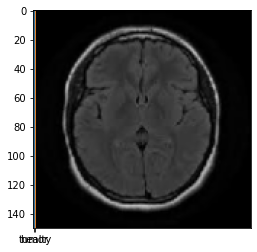

In [8]:
t=0
h=0
for i in range(15):
    a, b = next(train)
    for j in b:
        if j == 1:
            h+=1
        else:t+=1

sns.barplot(x=['tumor','healty'],y=[t,h])
import matplotlib.pyplot as plt
batch = next(train)

plt.imshow(batch[0][0])

In [9]:
from keras.layers import Conv2D, MaxPool2D, LeakyReLU, BatchNormalization, Dropout, Dense, InputLayer, Flatten, Input
from keras.losses import BinaryCrossentropy
from keras.optimizers import SGD
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from tensorflow.keras import layers

In [10]:
input_tensor = Input(shape=(100, 100, 3))  # this assumes K.image_data_format() == 'channels_last'

resnet_model = ResNet50(input_tensor=input_tensor,weights='imagenet', include_top=False)

for layer in resnet_model.layers:
    layer.trainable=False

resnet = Sequential()
resnet.add(resnet_model)
resnet.add(layers.Conv2D(32, kernel_size=(3,3), strides=(3,3), activation='relu', padding='same', input_shape=(100, 100, 1)))
resnet.add(layers.ReLU())
resnet.add(layers.MaxPooling2D(pool_size=(2,2)))
resnet.add(layers.Flatten())
resnet.add(layers.Dense(activation='relu', units=64))
resnet.add(layers.Dropout(0.2))
resnet.add(layers.Dense(activation='sigmoid', units=1))

resnet.compile(loss=BinaryCrossentropy(), optimizer=SGD(0.001), metrics=["accuracy"])

resnet.summary()

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 4d473c1dd8becc155b73f8504c6f6626 so we will re-download the data.
94773248/94765736 [==============================] - 9s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 2, 32)          589856    
_________________________________________________________________
re_lu (ReLU)                 (None, 2, 2, 32)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0   

In [11]:
from keras import utils, callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", 
                                        patience=5, restore_best_weights = True)

In [12]:
history = resnet.fit(train,verbose=1,callbacks = [earlystopping],epochs=20,validation_data=(val))

Epoch 1/20
15/15 [==============================] - 160s 11s/step - loss: 0.6848 - accuracy: 0.5520 - val_loss: 0.6829 - val_accuracy: 0.5745
Epoch 2/20
15/15 [==============================] - 216s 14s/step - loss: 0.6786 - accuracy: 0.5708 - val_loss: 0.6807 - val_accuracy: 0.5865
Epoch 3/20
15/15 [==============================] - 222s 15s/step - loss: 0.6724 - accuracy: 0.5974 - val_loss: 0.6774 - val_accuracy: 0.6094
Epoch 4/20
15/15 [==============================] - 204s 14s/step - loss: 0.6648 - accuracy: 0.6074 - val_loss: 0.6749 - val_accuracy: 0.5854
Epoch 5/20
15/15 [==============================] - 213s 14s/step - loss: 0.6639 - accuracy: 0.6134 - val_loss: 0.6710 - val_accuracy: 0.5909
Epoch 6/20
15/15 [==============================] - 217s 14s/step - loss: 0.6598 - accuracy: 0.6237 - val_loss: 0.6671 - val_accuracy: 0.5974
Epoch 7/20
15/15 [==============================] - 209s 14s/step - loss: 0.6517 - accuracy: 0.6409 - val_loss: 0.6617 - val_accuracy: 0.6333
Epoch 

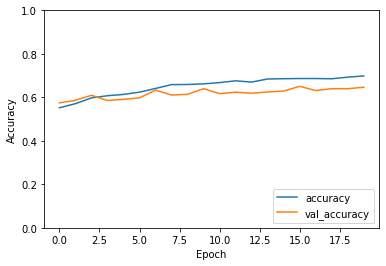

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')


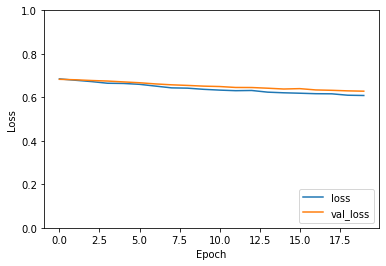

In [14]:

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [16]:
gen = ImageDataGenerator(rescale=1./255,zoom_range=(0.99,0.99),dtype=tf.float32)
test = gen.flow_from_directory("../../Test/DataSet/",
                               target_size = (150,150),
                               batch_size = 256,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = 123,
                               subset = "training")

classes = val.class_indices

Found 245 images belonging to 2 classes.


In [17]:
_, acc  = resnet.evaluate(test, verbose=1)

1/1 [==============================] - 0s 998us/step - loss: 0.5950 - accuracy: 0.7102
